In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\govin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('amazon_alexa.tsv',delimiter='\t',quoting=3)
data.head(15)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,"""I received the echo as a gift. I needed anoth...",1
6,3,31-Jul-18,Sandstone Fabric,"""Without having a cellphone, I cannot use many...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,"""Love it! I’ve listened to songs I haven’t hea...",1


In [3]:
data.isnull().sum()
# There is one record in reviews which is null

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [4]:
data[data['verified_reviews'].isna()]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [5]:
data.dropna(inplace=True)

In [6]:
data['length'] = data['verified_reviews'].apply(len)
data

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


In [7]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object


### Analyzing the rating column 

In [8]:
print( f"Rating column counts: \n {data['rating'].value_counts()} " )

Rating column counts: 
 rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64 


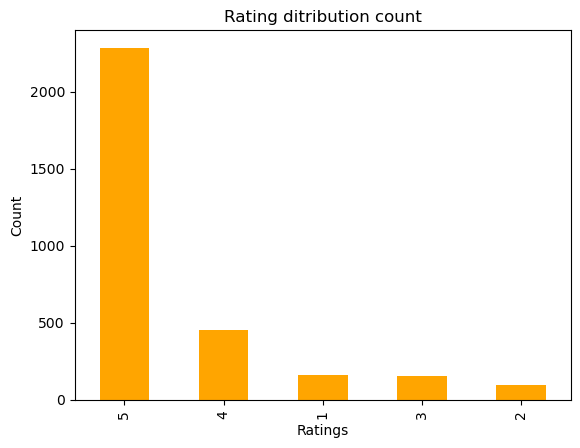

In [9]:
data['rating'].value_counts().plot.bar(color='orange')
plt.title('Rating ditribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

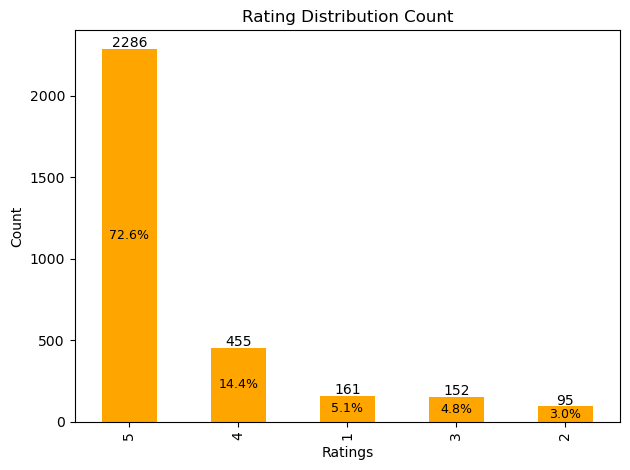

In [10]:


# Count values and calculate percentages
rating_counts = data['rating'].value_counts()
rating_percent = rating_counts / rating_counts.sum() * 100

# Plot bar chart
ax = rating_counts.plot.bar(color='orange')

# Add count at the top, percentage inside
for i, (count, percent) in enumerate(zip(rating_counts, rating_percent)):
    # Count on top of the bar
    ax.text(i, count + 10, str(count), ha='center', fontsize=10)
    
    # Percentage inside the bar
    ax.text(i, count * 0.5, f'{percent:.1f}%', ha='center', va='center', fontsize=9, color='black')

# Titles and labels
plt.title('Rating Distribution Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### Analyzing the Feedback Column

In [11]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

1 and 0 do not appear to indicate whether feedback has been provided.so, let's see what they truly represent.

In [12]:
reviews_0  = data[data['feedback'] == 0][['verified_reviews']]
pd.set_option('display.max_colwidth', None)
reviews_0

,verified_reviews
46,"""It's like Siri, in fact, Siri answers more accurately then Alexa. I don't see a real need for it in my household, though it was a good bargain on prime day deals."""
111,Sound is terrible if u want good music too get a bose
141,Not much features.
162,"""Stopped working after 2 weeks ,didn't follow commands!? Really fun when it was working?"""
176,Sad joke. Worthless.
...,...
3047,Echo Dot responds to us when we aren't even talking to it. I've unplugged it. It feels like it's &#34;spying&#34; on us.
3048,NOT CONNECTED TO MY PHONE PLAYLIST :(
3067,The only negative we have on this product is the terrible sound quality. A massive difference from the Alexa. Which to us was a big reason we wanted to purchase this.Won’t be buying another until the speaker and sound quality can improve.
3091,I didn’t order it


In [13]:
reviews_1 = data[data['feedback'] == 1][['verified_reviews']]
pd.set_option('display.max_colwidth', None)
reviews_1

,verified_reviews
0,Love my Echo!
1,Loved it!
2,"""Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you. I like being able to turn lights on and off while away from home."""
3,"""I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."""
4,Music
...,...
3145,"""Perfect for kids, adults and everyone in between!!"""
3146,"""Listening to music, searching locations, checking time, looking up weather. There are many more task to learn. It was simple to set up."""
3147,"""I do love these things, i have them running my entire home, TV, all my lights, my thermostat, my front door dead bolt, the cameras... and i love listening to npr. these things are well worth the value and they really shine once you stat adding smart devices and you can control your entire home like its right out of star trek.... I named mine computer to get the feel... but its amazing what you can do with these devices and smart systems."""
3148,"""Only complaint I have is that the sound quality isn't great. I mostly use it for commands though, and I have another dot hooked up to my stereo system to play music through. I have a couple friends that have a dot and don't mind the audio quality, but if you're bothered by that kind of thing I'd go with the full size echo or make sure you hook the do up to some larger speakers."""


After looking at the data, it's clear that 1 is positive reviews while 0 is negative.

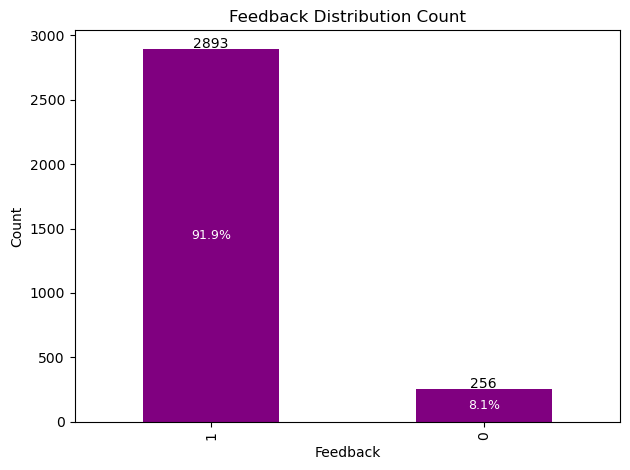

In [14]:


# Count values and calculate percentages
rating_counts = data['feedback'].value_counts()
rating_percent = rating_counts / rating_counts.sum() * 100

# Plot bar chart
ax = rating_counts.plot.bar(color='purple')

# Add count at the top, percentage inside
for i, (count, percent) in enumerate(zip(rating_counts, rating_percent)):
    # Count on top of the bar
    ax.text(i, count + 10, str(count), ha='center', fontsize=10)
    
    # Percentage inside the bar
    ax.text(i, count * 0.5, f'{percent:.1f}%', ha='center', va='center', fontsize=9, color='white')

# Titles labels
plt.title('Feedback Distribution Count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [15]:
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [16]:
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

Rating 1 and 2 are negative feedback rating and Rating 3,4 and 5 are positive feedback ratings

### Analzing the variation column

In [17]:
print( f"Variation column counts: \n {data['variation'].value_counts()} " )

Variation column counts: 
 variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64 


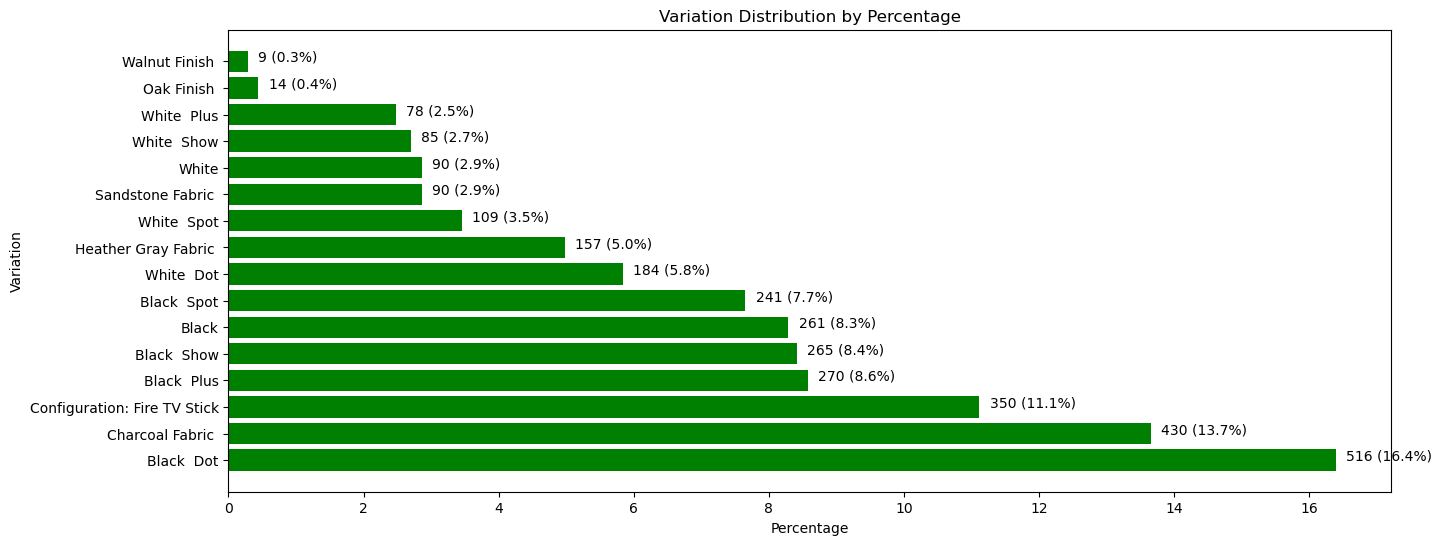

In [18]:

variation_counts = data['variation'].value_counts()
variation_percent = variation_counts / variation_counts.sum() * 100


plt.figure(figsize=(15, 6))
plt.barh(variation_counts.index, variation_percent, color='green')


plt.title('Variation Distribution by Percentage')
plt.xlabel('Percentage')
plt.ylabel('Variation')

# Show exact percentage and count on the bars
for index, value in enumerate(variation_percent):
    plt.text(value + 0.15, index, f'{variation_counts.iloc[index]} ({value:.1f}%)')

plt.show()


In [19]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review')]

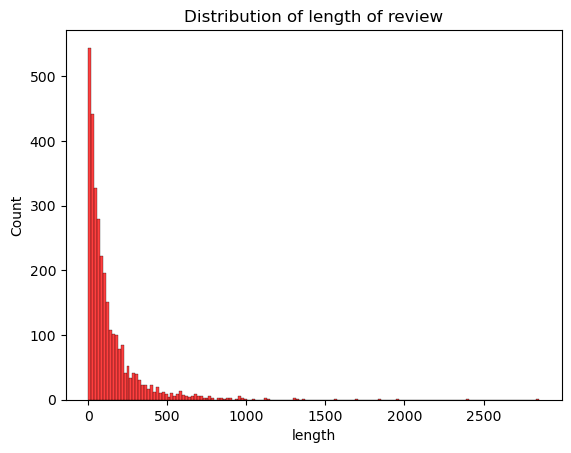

In [20]:
sns.histplot(data['length'],color='red').set(title = "Distribution of length of review")

[Text(0.5, 1.0, 'Distribution of length of review for positive feedback (1)')]

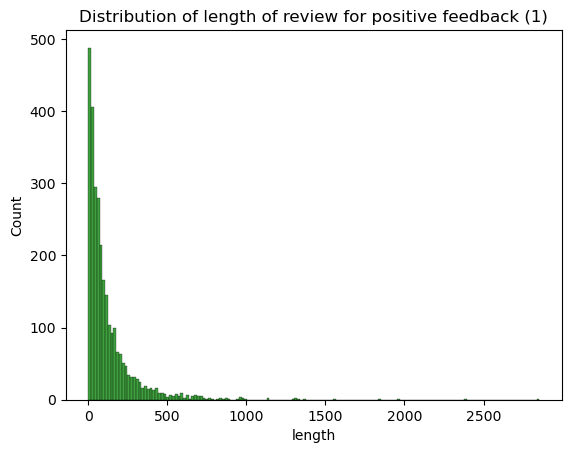

In [21]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title = "Distribution of length of review for positive feedback (1)")

[Text(0.5, 1.0, 'Distribution of length of review for negative feedback (0)')]

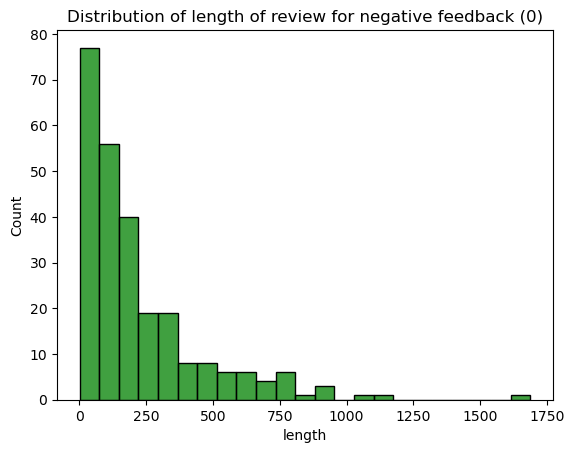

In [22]:
sns.histplot(data[data['feedback']==0]['length'],color='green').set(title = "Distribution of length of review for negative feedback (0)")

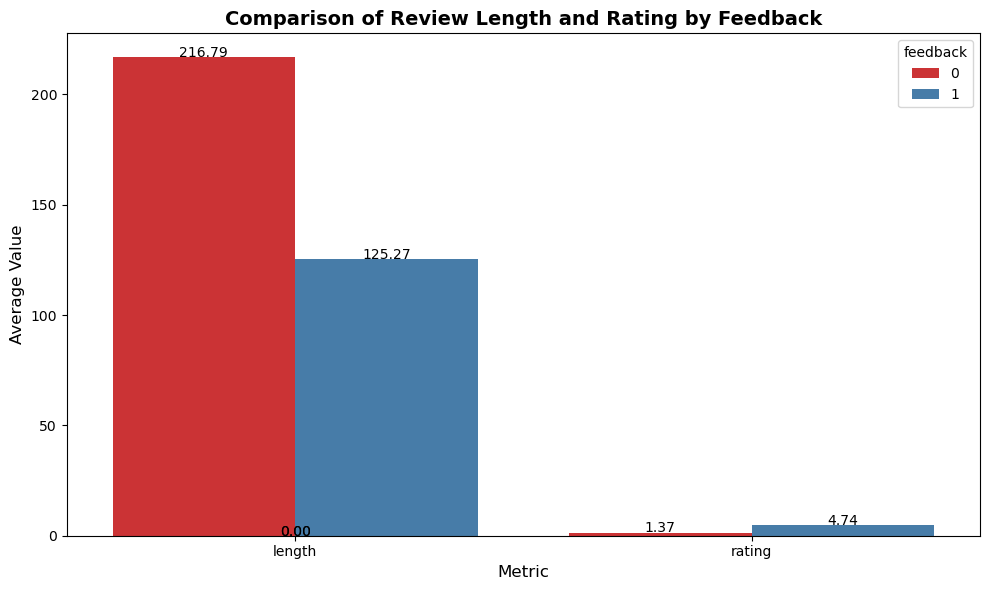

In [23]:

# Calculate averages for feedback 1 and 0
avg_values = data.groupby('feedback').agg({'length': 'mean', 'rating': 'mean'}).reset_index()

# Prepare data for plotting
avg_values = avg_values.melt(id_vars='feedback', value_vars=['length', 'rating'], var_name='Metric', value_name='Average')

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Average', hue='feedback', data=avg_values, palette='Set1')

# Set title and labels
plt.title("Comparison of Review Length and Rating by Feedback", fontsize=14, weight='bold')
plt.ylabel("Average Value", fontsize=12)
plt.xlabel("Metric", fontsize=12)

# Add numbers above each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, f'{p.get_height():.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


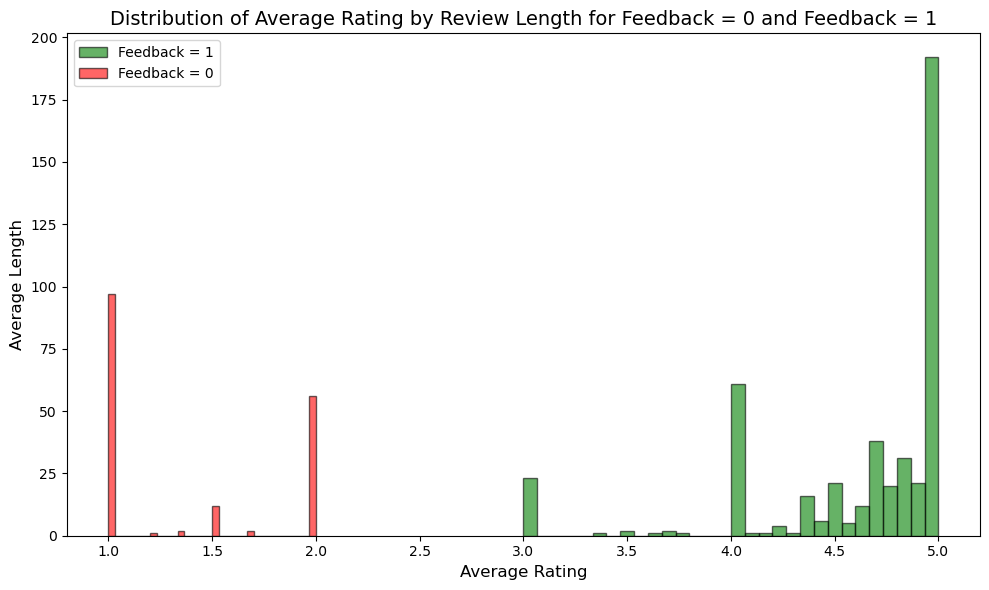

In [24]:


# Grouping data by length and calculating average rating
avg_rating_feedback_1 = data[data['feedback'] == 1].groupby('length')['rating'].mean()
avg_rating_feedback_0 = data[data['feedback'] == 0].groupby('length')['rating'].mean()

# Plotting histograms for feedback = 1 and feedback = 0
plt.figure(figsize=(10, 6))
plt.hist(avg_rating_feedback_1, bins=30, color='green', alpha=0.6, label='Feedback = 1', edgecolor='black')
plt.hist(avg_rating_feedback_0, bins=30, color='red', alpha=0.6, label='Feedback = 0', edgecolor='black')

# Add title and labels
plt.title('Distribution of Average Rating by Review Length for Feedback = 0 and Feedback = 1', fontsize=14)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Average Length', fontsize=12)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Here, we can see that positive ratings 3 - 5 have more length then negative reviews 0-1.
So, people tend to leave longer more detailed reviews for products they like and shorter reviews for products that they dislike

In [25]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

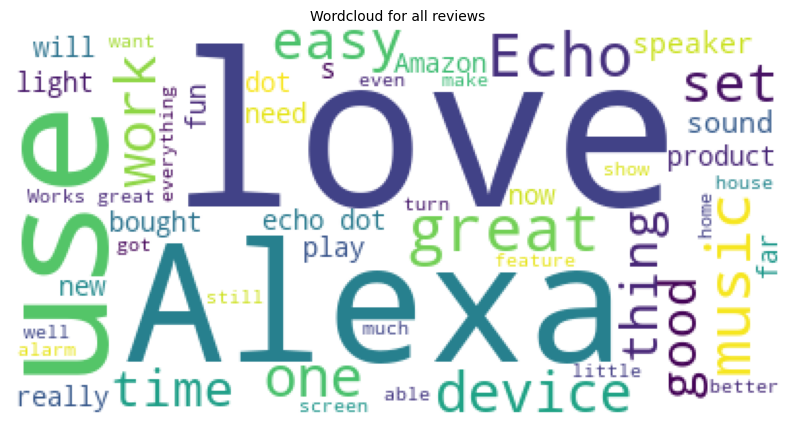

In [26]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

### Wordcloud for Positive and Negative Reviews

In [27]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

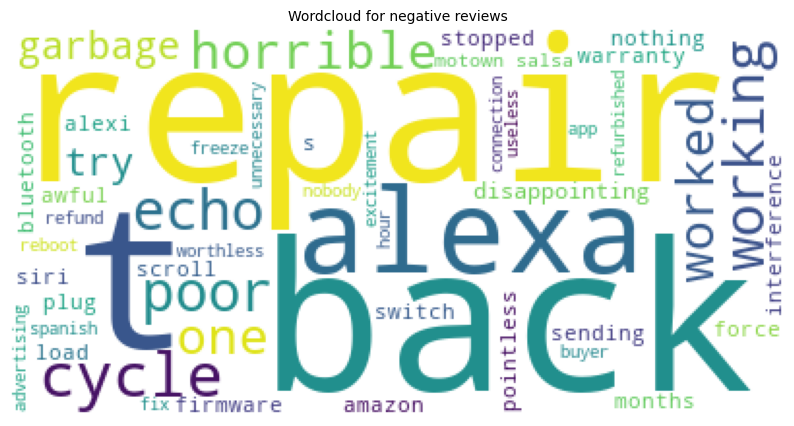

In [28]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

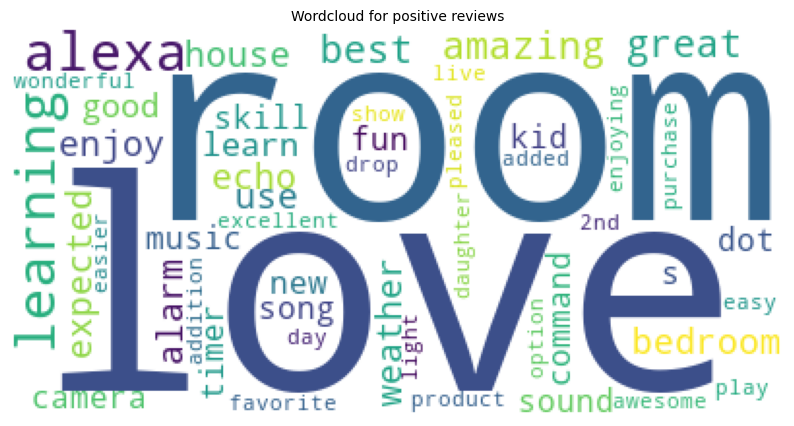

In [29]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

### Preprocessing and Modelling

In [30]:


# Split data
X = data['verified_reviews']
y = data['feedback']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2500)),
    ('rf', RandomForestClassifier())
])

# Fit model
model.fit(X_train, y_train)

# Accuracy scores
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Testing Accuracy:", accuracy_score(y_test, test_preds))

# Optional: detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, test_preds))


joblib.dump(model, 'Models/sentiment_pipeline_TFIDF.joblib')


Training Accuracy: 0.9927404718693285
Testing Accuracy: 0.9206349206349206

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.20      0.32        92
           1       0.92      1.00      0.96       853

    accuracy                           0.92       945
   macro avg       0.93      0.60      0.64       945
weighted avg       0.92      0.92      0.90       945



['Models/sentiment_pipeline_TFIDF.joblib']

In [31]:

loaded_model = joblib.load('Models/sentiment_pipeline_TFIDF.joblib')


test_review = ["The product was bad"]
prediction = loaded_model.predict(test_review)


label_map = {1: "Positive", 0: "Negative"}
print("Prediction:", label_map[prediction[0]])

Prediction: Positive
